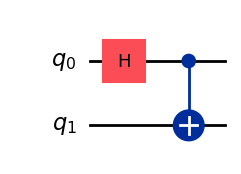

In [2]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1) 

qc.draw(output='mpl')

In [3]:
from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli("ZI")
IZ = Pauli("IZ")
XX = Pauli("XX")
XI = Pauli("XI")
IX = Pauli("IX")

observables = [ZZ, ZI, IZ, XX, XI, IX]

# Step 2: Optimize 

In [4]:
# Step 3: Execute on backend

from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)

job.result()

EstimatorResult(values=array([1.        , 0.00976562, 0.00976562, 1.        , 0.00976562,
       0.00976562]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'time_taken': 0.001990741, 'num_bind_params': 1, 'parallel_state_update': 2, 'parallel_shots': 1, 'required_memory_mb': 0, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'stabilizer', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.000687522, 'active_input_qubits': [0, 1], 'num_clbits': 2, 'remapped_qubits': False, 'runtime_parameter_bind': False, 'max_memory_mb': 6580, 'noise': 'ideal', 'measure_sampling': True, 'batched_shots_optimization': False, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9999046325683594, 'simulator_metadata': [{'time_taken': 0.001990741, 'num_bind_params': 1, 'parallel_state_update': 2, 'parallel_shots': 1, 'required_memory_mb': 0, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'stabilizer', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.000687522

Extend to an $n$-Qubit GHZ state

In [5]:
## Step 1: Map the problem to circuits and operators

def get_qc_for_n_qbit_state(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n-1):
        qc.cx(i, i+1)
    return qc

n = 100
qc = get_qc_for_n_qbit_state(n)
# qc.draw(output='mpl')

In [6]:
from qiskit.quantum_info import SparsePauliOp

operator_strings = ['Z' + 'I' * i + 'Z' + 'I' * (n-2-i) for i in range(n-1)]
print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(operator_string) for operator_string in operator_strings]

['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

## Step 2: Optimize problem for quntum execution

In [7]:


from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend_name = "ibm_brisbane"
backend = QiskitRuntimeService().backend(backend_name)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled = pass_manager.run(qc)
operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators]

## Step 3: Execute on the backend

In [8]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()
options.resilience_level = 1
# options.optimization_level = 0
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator(backend, options=options)

job = estimator.run([(qc_transpiled, operators_transpiled_list)])
job_id = job.job_id()
print(job_id)

cxr2hn6y1ae0008n1310


## Step 4: Post-process and plot

In [10]:
job_id='cxqhfge4a290008xk720' # cxr2hn6y1ae0008n1310
service = QiskitRuntimeService()
job = service.job(job_id)

RuntimeJobNotFound: 'Job not found: 404 Client Error: Not Found for url: https://api.quantum.ibm.com/runtime/jobs/cxqhfge4a290008xk720. {"errors":[{"code":1291,"message":"Job not found. Job ID: cxqhfge4a290008xk720","solution":"Verify the job ID is correct, and that you have the correct access permissions.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}'

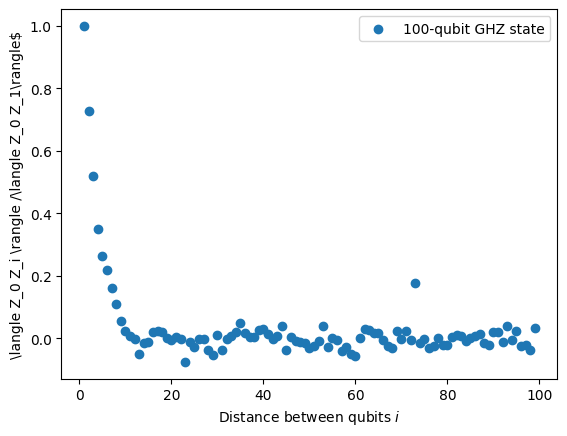

In [27]:
import matplotlib.pyplot as plt

data = list(range(1, len(operators)+1))
result = job.result( ) [0]
values = result.data.evs
values = [v / values [0] for v in values]

plt.scatter(data, values, marker='o', label='100-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'\langle Z_0 Z_i \rangle /\langle Z_0 Z_1\rangle$')
plt. legend()
plt.show()